In [2]:
import pandas as pd
import gzip
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForMaskedLM

/mnt2/wisniewski/nazanin/NeuralLMs/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

tokenizer = AutoTokenizer.from_pretrained('google/multiberts-seed_0')
# model = AutoModelForMaskedLM.from_pretrained('google/multiberts-seed_0').to(device)

cuda


## Surprisals

In [24]:
surprisals = pd.read_csv('../results/toy_surprisals.txt', sep='\t')
surprisals

,Steps,Token,MedianRank,MeanSurprisal,StdevSurprisal,Accuracy,NumExamples
0,0,constraint,7480,14.581974,NaN,0.000000,1
1,0,exploring,9474,14.721372,NaN,0.000000,1
2,0,of,142,13.217982,0.359066,0.000000,512
3,0,the,27912,16.013855,0.386750,0.000000,512
4,20000,constraint,2790,16.842049,NaN,0.000000,1
...,...,...,...,...,...,...,...
111,1900000,the,0,0.387125,0.949621,0.923828,512
112,2000000,constraint,728,14.549789,NaN,0.000000,1
113,2000000,exploring,56,10.402106,NaN,0.000000,1
114,2000000,of,0,0.336895,1.169644,0.949219,512


## View attentions matrices

The self-attention $a_{j \rightarrow i}$ describes how important is the $j$-th token to build the representation of the $i$-th token. We know that $a_{j \leftarrow j}$ is a probability distribution.

The encoder attention is a list of **12** tensors, one for each `BertEncoderLayer` in the model.

Each attention is a `[batch_size ✕ n_heads ✕ input_sequence_length ✕ input_sequence_length]`.

**Example:**

the attention weight of the second_last token (-2) in the first attention head (0) of the last layer (-1), with respect to the third token (2):

`attentions[-1][0][-2][2]`

In [11]:
def attention_matrices(attentions, sequence, tokenizer):
    n_heads = attentions.shape[0]
    seq_tokens = tokenizer.tokenize(sequence)
    seq_len = len(seq_tokens)
    fig, ax = plt.subplots(n_heads, 1, figsize=(seq_len // 4, n_heads), sharex=True)

    for layer in range(n_heads):
        plt.sca(ax[layer])
        # Remove padding tokens from attention matrix
        self_attention = attentions[layer, :seq_len]

        df_attention = pd.DataFrame(data=self_attention.reshape(1, -1),  # Reshape to a row vector
                                    index=['[MASK]'],
                                    columns=seq_tokens)

        plot = sns.heatmap(df_attention, cmap="crest")
        plot.set_xticklabels(plot.get_xticklabels(), rotation=90)
        plot.set_xlabel("tokens")
        # plot.set_ylabel("[MASK]")

    plt.tight_layout()
    plt.show()

In [52]:
with gzip.open('../results/lexique_results/4ex_att_hs.pickle.gz', 'rb') as f:
    toy_att_hs = pickle.load(f)

toy_att_hs = pd.DataFrame(toy_att_hs)
toy_att_hs

,step,masked_token_identity,sequence,1st_layer_attentions,6th_layer_attentions,last_layer_attentions,1st_layer_hidden_states,6th_layer_hidden_states,last_layer_hidden_states
0,0,constraint,[CLS] turan cited ball's lack of [MASK] when w...,"[[0.012571751, 0.010714171, 0.011511954, 0.015...","[[0.018160338, 0.01111132, 0.013891903, 0.0135...","[[0.015209573, 0.012172604, 0.015836501, 0.015...","[0.5670556, -0.70738256, 0.16242988, -0.324278...","[1.6499794, -0.1876529, 0.93366903, -0.6897908...","[0.63210857, -0.73800594, 0.6110188, -1.090390..."
1,0,exploring,[CLS] these two were interested in [MASK] gree...,"[[0.008456928, 0.007806724, 0.009046795, 0.009...","[[0.010955145, 0.0107101835, 0.012544594, 0.00...","[[0.010097867, 0.009157432, 0.008794111, 0.009...","[0.79489565, 0.25571832, 0.21407825, -0.886555...","[1.2451073, 0.849074, 0.42493585, -0.9130812, ...","[0.41850048, 0.16003795, 0.70800537, -1.743492..."
2,0,of,"[CLS] in 2004 boulter landed a role as "" craig...","[[0.01106577, 0.0093897125, 0.013108689, 0.013...","[[0.012527992, 0.012198372, 0.018467387, 0.009...","[[0.013655885, 0.013197703, 0.011173694, 0.012...","[0.23898314, -0.04438965, 0.27684808, -0.77728...","[1.1704011, 0.68887734, 0.23094317, -1.2730061...","[0.28884137, 0.3650714, 0.22665274, -1.336198,..."
3,0,of,[CLS] he appeared on a 2006 episode of the tel...,"[[0.014630453, 0.016211314, 0.020322401, 0.021...","[[0.024409054, 0.016248606, 0.023940427, 0.018...","[[0.019966517, 0.018131513, 0.022161791, 0.019...","[0.41802138, -0.25577322, -0.20876332, -0.1595...","[1.1569152, 0.38195136, 0.34435204, -0.7836391...","[0.73960817, 0.58608264, -0.049873885, -1.3096..."
4,0,of,"[CLS] boulter starred in two films in 2008, da...","[[0.011374782, 0.010010656, 0.009217238, 0.013...","[[0.018214481, 0.013004199, 0.015303743, 0.016...","[[0.015352399, 0.015326607, 0.013585413, 0.015...","[1.2334197, -1.3070036, 0.16137847, -1.126705,...","[2.2352388, -0.50653833, 0.17799391, -1.563299...","[0.93771005, -0.47364503, 0.17385846, -1.48324..."
...,...,...,...,...,...,...,...,...,...
29749,2000000,the,"[CLS] the us units rapidly pursued them north,...","[[0.027374448, 0.015824258, 0.014114257, 0.027...","[[0.15225765, 0.03869245, 0.015217652, 0.00496...","[[0.0025055488, 0.009956588, 0.014172591, 0.00...","[-0.10119108, -0.27444592, -0.06236407, 0.0525...","[0.06643793, -0.6205415, 0.27648848, 0.0650269...","[-0.23755552, -0.17224884, 0.16723588, -0.1101..."
29750,2000000,the,"[CLS] the 9th division had numbered 9 @, @ 350...","[[0.026722398, 0.01997395, 0.0350497, 0.041097...","[[0.1615782, 0.014106403, 0.00047053111, 0.003...","[[0.00063792884, 0.0010529711, 0.0019629202, 0...","[0.063478716, -0.14458703, 0.005222332, -0.106...","[0.2381054, -0.1480205, -0.3608656, 0.04885430...","[-0.26082405, 0.5913237, -0.114842474, 0.24704..."
29751,2000000,the,[CLS] only a few hundred from each division re...,"[[0.028685467, 0.03094041, 0.0315416, 0.027997...","[[0.17141737, 0.0018551223, 0.0011837095, 0.00...","[[0.0025107542, 0.0016413133, 0.00039148834, 0...","[0.063478716, -0.14458703, 0.005222332, -0.106...","[0.17005913, -0.10359372, 0.15532276, -0.15535...","[-0.1056963, 0.24460368, 0.07110799, 0.1381676..."
29752,2000000,the,[CLS] all of nk ii corps was in a similar stat...,"[[0.017755907, 0.0069801, 0.009407186, 0.01592...","[[0.12027704, 0.0014476371, 0.0039697657, 0.01...","[[0.0011465088, 0.0064695273, 0.0013179729, 0....","[0.24555206, -0.22167869, 0.106187284, -0.1921...","[0.37084863, 0.12804917, 0.17674069, -0.278320...","[-0.10433017, 0.36715254, 0.0063810498, -0.126..."


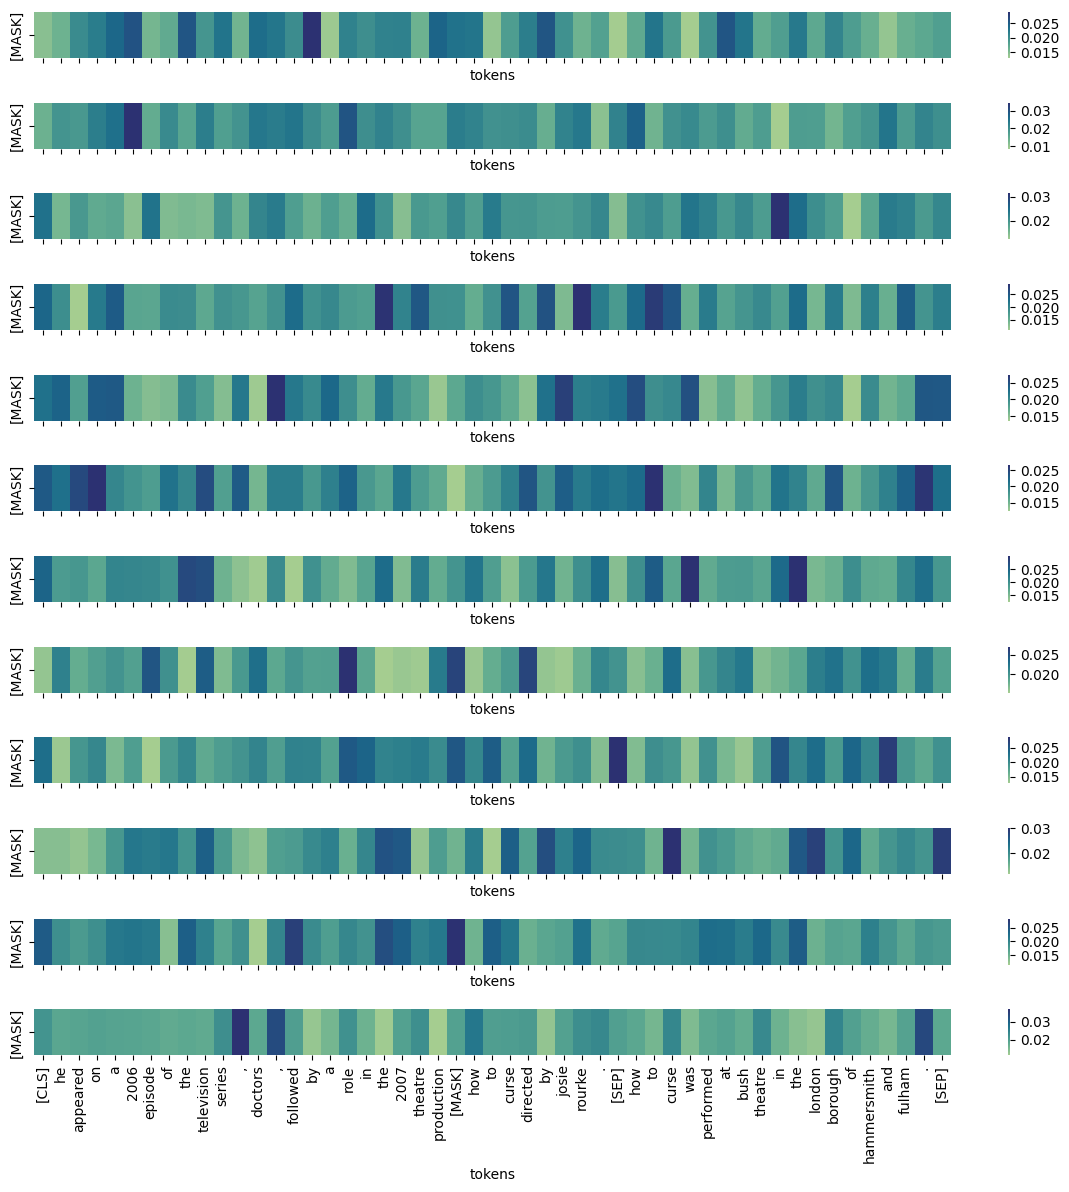

In [53]:
row = toy_att_hs.iloc[3]
attention_matrices(row['1st_layer_attentions'], row['sequence'], tokenizer)

In [67]:
from scipy.stats import wasserstein_distance

def get_EMDs(attentions1, attentions2):
    n_heads = attentions1.shape[0]

    EMDs = []
    for head in range(n_heads):
        att_vector1 = attentions1[head, :]
        att_vector2 = attentions2[head, :]

        EMDs.append(wasserstein_distance(att_vector1, att_vector2))
    
    return EMDs

In [88]:
token_data = toy_att_hs[toy_att_hs.masked_token_identity == 'constraint']

In [90]:
v1 = torch.tensor(token_data[token_data.step == 0]['1st_layer_attentions'].tolist()).squeeze()
v2 = torch.tensor(token_data[token_data.step == 20000]['1st_layer_attentions'].tolist()).squeeze()
get_EMDs(v1, v2)

[0.009543653545038335,
 0.01133229280993178,
 0.011194018858505468,
 0.007921547260861295,
 0.00799992833430331,
 0.009618932208361323,
 0.010186939726682952,
 0.0064263022299308106,
 0.01103985931310008,
 0.012311080694095887,
 0.012633083305605822,
 0.005279629210503222]

## View hidden states

The encoder hidden_states is a list of **13** tensors, which are the inputs and outputs of each `BertEncoderLayer` in the model.

Each hidden_state is a `[batch_size ✕ input_sequence_length ✕ hidden_size]`.

**Example:**

The first hidden state on the last layer: `hidden_states[-1][0, :]`